In [442]:
import numpy as np
import pandas as pd
import cv2
import glob

from scipy.ndimage.measurements import label

from skimage.feature import hog
from skimage import color, exposure

from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

from lesson_functions import *

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [199]:
nonvehicles = pd.DataFrame(glob.glob('./non-vehicles/*/*.png'), columns=['image'])
nonvehicles['label'] = 0

vehicles = pd.DataFrame(glob.glob('./vehicles/*/*.png'), columns=['image'])
vehicles['label'] = 1

In [200]:
print('Number of vehicle samples is:')
print(vehicles['image'].shape)
print('Number of nonvehicle samples is: ')
print(nonvehicles['image'].shape)
print('Shape of an image is:')
print(mpimg.imread(vehicles['image'].iloc[0]).shape)

Number of vehicle samples is:
(8792,)
Number of nonvehicle samples is: 
(8968,)
Shape of an image is:
(64, 64, 3)


In [201]:
def process_image(img, color_space='RGB', spatial_size=(32, 32),
                 hist_bins=(32, 32), orient=9, pix_per_cell=8,
                 cell_per_block=2, hog_channel=0, spatial_feat=True,
                  hist_feat=True, hog_feat=True):
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [483]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = process_image(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    window_of_interest = on_windows
    return on_windows

In [484]:
def add_heat(heatmap, box):
    # for box in bbox_list:
    heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
    
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

In [557]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    bboxes =[]
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img, bboxes

In [486]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [360, None] # Min and max in y to search in slide_window()

In [487]:
car_features = extract_features(vehicles['image'], color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(nonvehicles['image'], color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

In [488]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

In [473]:
y = np.hstack((vehicles['label'], nonvehicles['label']))

In [474]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)

In [475]:
svc = LinearSVC()

svc.fit(X_train, y_train)

accuracy = svc.score(X_test, y_test)
print(accuracy)

0.986768018018


In [476]:
image = mpimg.imread('./test_images/test6.jpg')
draw_image = np.copy(image)

image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

In [477]:
heatmap = np.zeros_like(image[:,:,0]).astype(np.float32)

for idx, boxlist in enumerate(hot_windows):
    add_heat(heatmap, boxlist)

[((816, 384), (959, 503)), ((1032, 408), (1199, 527))]
((1032, 408), (1199, 527))


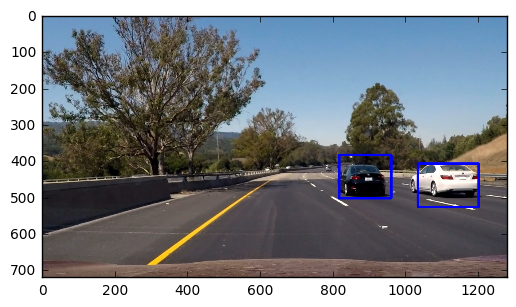

In [565]:
final_heatmap = apply_threshold(heatmap, 1)
labels = label(final_heatmap)
window_img, bbox_list = draw_labeled_bboxes(draw_image, labels) 

#window_img = draw_boxes(draw_image, hot_windows)
plt.imshow(window_img)
del final_heatmap

In [479]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

[((96, 360), (192, 456)), ((120, 360), (216, 456))]
(96, 360)


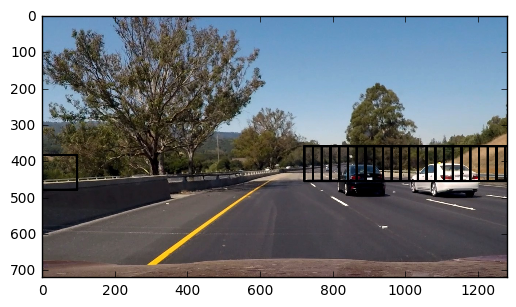

In [553]:
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))
plt.imshow(draw_boxes(image, windows[30:53]))
print(windows[4:6])
print(windows[4:6][0][0])
first = True
window_of_interest = None

In [577]:
def process_frame(image):
    draw_image = np.copy(image)

    image = image.astype(np.float32)/255
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float32)

    for idx, boxlist in enumerate(hot_windows):
        add_heat(heatmap, boxlist)
        
    final_heatmap = apply_threshold(heatmap, 1)
    labels = label(final_heatmap)

    window_img, bboxes = draw_labeled_bboxes(draw_image, labels)
    try:
        x_start_stop = [bboxes[0][0][0] - 100, bboxes[-1][-1][-1] + 100]
    except:
        x_start_stop = [None, None]
    print(x_start_stop)
    return window_img

In [578]:
video_output = "output1.mp4"
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(process_frame)
%time clip.write_videofile(video_output, audio=False)

[None, None]
[MoviePy] >>>> Building video output1.mp4
[MoviePy] Writing video output1.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:02<59:55,  2.85s/it]

[None, None]





  0%|          | 2/1261 [00:05<59:41,  2.84s/it]

[None, None]





  0%|          | 3/1261 [00:08<59:22,  2.83s/it]

[None, None]


KeyboardInterrupt: 

In [469]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))